In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, FunctionTransformer, MinMaxScaler, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn_pandas import DataFrameMapper  # If still needed, otherwise remove
import joblib
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, MDS  # Combined TSNE and MDS
import seaborn as sns
from tslearn.metrics import cdist_dtw
from sklearn.cluster import KMeans
from tslearn.clustering import TimeSeriesKMeans
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Design
- Using Credit Card Transaction dataset from IBM (~24M records)
- Due to hardware limitation, this experiment only uses half of total transaction data and capture their latest month of transactions 

## Baseline Approach : Daily aggregate  
Simply create aggregated sequence of total daily transaction amount by each user-card pair

In [112]:
import os
import pandas as pd
import numpy as np

# Function to create daily sequences for the latest month per User-Card
def create_daily_sequences(df, id_cols, time_col, value_col):
    sequences = []
    ids = []  # Store user-card combinations

    # Ensure id_cols is a list
    if isinstance(id_cols, str):
        id_cols = [id_cols]

    # Convert time column to datetime
    df[time_col] = pd.to_datetime(df[time_col], errors='coerce')

    # Create "Year-Month" column
    df['Year-Month'] = df[time_col].dt.to_period('M')

    # Extract day
    df['Day'] = df[time_col].dt.day

    # Group by User-Card
    for (user, card), group in df.groupby(id_cols):
        # Find the latest "Year-Month" for this user-card
        latest_month = group['Year-Month'].max()

        # Filter transactions for this latest month
        latest_month_group = group[group['Year-Month'] == latest_month]

        # Generate a full list of days (1–31) for the month
        full_days = pd.DataFrame({'Day': np.arange(1, 32)})  # 1 to 31

        # Sum transactions per day
        daily_sums = latest_month_group.groupby('Day')[value_col].sum().reset_index()

        # Merge with full day range to fill missing days with 0
        daily_sums = full_days.merge(daily_sums, on='Day', how='left').fillna(0)

        # Ensure only valid days remain
        valid_days = pd.date_range(f'{latest_month}-01', periods=31, freq='D')
        valid_days = valid_days[valid_days.month == latest_month.month].day  # Keep only valid days
        daily_sums = daily_sums[daily_sums['Day'].isin(valid_days)]

        # Store sequence and ID
        sequences.append(daily_sums[value_col].values)  # Only amount sequence
        ids.append([user, card, latest_month])  # Store latest month info

    return sequences, ids

# Process Parquet files
folder_path = 'dataset'  # Folder path
final_sequences = []
final_ids = []

for filename in os.listdir(folder_path):
    if filename.endswith(".parquet"):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_parquet(file_path)

        # Create datetime column if missing
        df['datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day']].astype(str).agg('-'.join, axis=1) + ' ' + df['Time'])

        # Generate daily sequences
        sequences, ids = create_daily_sequences(df, ['User', 'Card'], 'datetime', 'Amount')

        # Append to final lists
        final_sequences.extend(sequences)
        final_ids.extend(ids)

# Check output
print(f"Processed {len(final_sequences)} User-Card pairs.")
print("Sample sequence:", final_sequences[0])  # Example sequence
print("Sample ID:", final_ids[0])  # Example user-card with latest month


Processed 1020 User-Card pairs.
Sample sequence: [  0.     0.   -32.34   0.     0.   145.65   0.     0.     0.     0.
   0.     0.     0.    30.52 940.91   0.    29.62   0.     5.56  33.34
   0.     0.     0.     0.     0.     0.    42.99 201.68 105.76   0.
   0.  ]
Sample ID: [17, 2, Period('2018-08', 'M')]


## Compute dtw

In [ ]:
# Function to compute DTW in batches
def compute_dtw_in_batches(sequences, batch_size=100, sakoe_chiba_radius=3):
    dtw_distances = []
    num_batches = len(sequences) // batch_size + (1 if len(sequences) % batch_size != 0 else 0)

    for batch_num in range(num_batches):
        batch_start = batch_num * batch_size
        batch_end = min((batch_num + 1) * batch_size, len(sequences))
        
        # Compute DTW for this batch
        batch_dtw = cdist_dtw(sequences[batch_start:batch_end], sequences, 
                             global_constraint="sakoe_chiba", sakoe_chiba_radius=sakoe_chiba_radius)
        dtw_distances.append(batch_dtw)

        # Print batch progress
        print(f"Processed batch {batch_num + 1}/{num_batches} (Rows {batch_start} to {batch_end-1})")

    return np.concatenate(dtw_distances, axis=0)  # Combine all batches

In [ ]:
# Example usage - Run in batch 
start_dt = datetime.now()
dtw_distances = compute_dtw_in_batches(final_sequences, batch_size=50)  # Adjust batch size as needed
print('Run time:', datetime.now() - start_dt)

Processed batch 1/56 (Rows 0 to 49)
Processed batch 2/56 (Rows 50 to 99)
Processed batch 3/56 (Rows 100 to 149)
Processed batch 4/56 (Rows 150 to 199)
Processed batch 5/56 (Rows 200 to 249)
Processed batch 6/56 (Rows 250 to 299)
Processed batch 7/56 (Rows 300 to 349)
Processed batch 8/56 (Rows 350 to 399)
Processed batch 9/56 (Rows 400 to 449)
Processed batch 10/56 (Rows 450 to 499)
Processed batch 11/56 (Rows 500 to 549)
Processed batch 12/56 (Rows 550 to 599)
Processed batch 13/56 (Rows 600 to 649)
Processed batch 14/56 (Rows 650 to 699)
Processed batch 15/56 (Rows 700 to 749)
Processed batch 16/56 (Rows 750 to 799)
Processed batch 17/56 (Rows 800 to 849)
Processed batch 18/56 (Rows 850 to 899)
Processed batch 19/56 (Rows 900 to 949)
Processed batch 20/56 (Rows 950 to 999)
Processed batch 21/56 (Rows 1000 to 1049)
Processed batch 22/56 (Rows 1050 to 1099)
Processed batch 23/56 (Rows 1100 to 1149)
Processed batch 24/56 (Rows 1150 to 1199)
Processed batch 25/56 (Rows 1200 to 1249)
Proc

In [ ]:
# Run K-Means on the DTW distance matrix
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(dtw_distances)

print('Run time:',datetime.now()-start_dt)

# Map labels back to user-card combinations
label_mapping = pd.DataFrame({
    'User': [id_pair[0] for id_pair in final_ids],
    'Card': [id_pair[1] for id_pair in final_ids],
    'Label': labels
})

# Print the label mapping DataFrame
print(label_mapping['Label'].value_counts(dropna=False))

Run time: 0:10:39.323389
Label
3    1679
0     681
2     296
1      96
Name: count, dtype: int64



🔹 K-Means Clustering Results:
   Silhouette Score: 0.2039
   Calinski-Harabasz Index: 6173.9085
   Davies-Bouldin Index: 0.6451

🔹 Hierarchical Clustering Results:
   Silhouette Score: 0.7234
   Calinski-Harabasz Index: 60.2013
   Davies-Bouldin Index: 0.1015

🔹 DBSCAN Clustering Results:
   Silhouette Score: nan
   Calinski-Harabasz Index: nan
   Davies-Bouldin Index: nan

🔹 Spectral Clustering Results:
   Silhouette Score: -0.1222
   Calinski-Harabasz Index: 50.9704
   Davies-Bouldin Index: 5.7540

🔹 HDBSCAN Clustering Results:
   Silhouette Score: nan
   Calinski-Harabasz Index: nan
   Davies-Bouldin Index: nan

📌 Clustering Performance Summary:
       Algorithm  Silhouette  Calinski-Harabasz  Davies-Bouldin
0       K-Means    0.203860        6173.908486        0.645085
1  Hierarchical    0.723447          60.201343        0.101463
2        DBSCAN         NaN                NaN             NaN
3      Spectral   -0.122240          50.970427        5.753964
4       HDBSCAN         Na

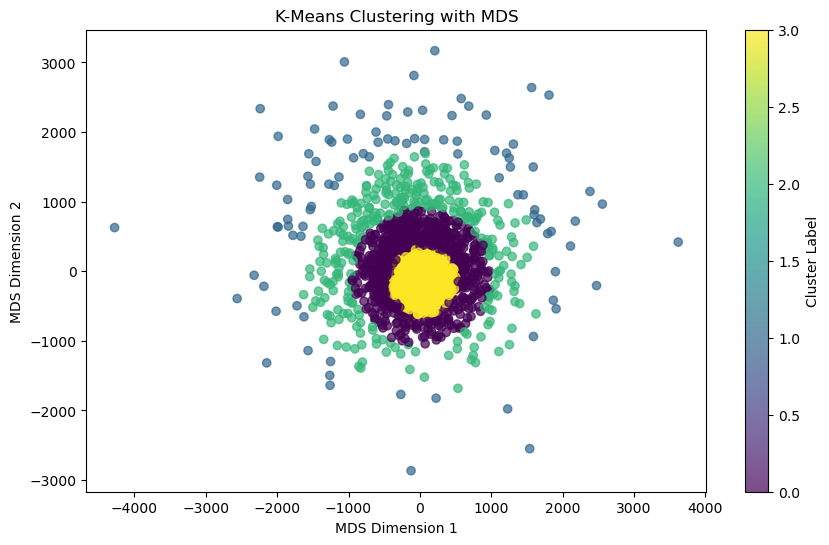

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
import hdbscan
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import MDS

# Function to evaluate clustering
def evaluate_clustering(dtw_distances, labels, name):
    if len(set(labels)) > 1 and -1 not in labels:  # Ensure valid clusters
        silhouette = silhouette_score(dtw_distances, labels, metric="precomputed")
        calinski = calinski_harabasz_score(dtw_distances, labels)
        davies = davies_bouldin_score(dtw_distances, labels)
    else:
        silhouette, calinski, davies = np.nan, np.nan, np.nan  # Invalid clustering (e.g., all points in 1 cluster)
    
    print(f"\n🔹 {name} Clustering Results:")
    print(f"   Silhouette Score: {silhouette:.4f}")
    print(f"   Calinski-Harabasz Index: {calinski:.4f}")
    print(f"   Davies-Bouldin Index: {davies:.4f}")
    
    return {"Algorithm": name, "Silhouette": silhouette, "Calinski-Harabasz": calinski, "Davies-Bouldin": davies}

# Store results
results = []
n_clusters=4
# 📌 K-Means Clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels_kmeans = kmeans.fit_predict(dtw_distances)
results.append(evaluate_clustering(dtw_distances, labels_kmeans, "K-Means"))

# 📌 Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=n_clusters, metric="precomputed", linkage="average")
labels_hierarchical = hierarchical.fit_predict(dtw_distances)
results.append(evaluate_clustering(dtw_distances, labels_hierarchical, "Hierarchical"))

# 📌 DBSCAN Clustering
dbscan = DBSCAN(eps=10, min_samples=5, metric="precomputed")
labels_dbscan = dbscan.fit_predict(dtw_distances)
results.append(evaluate_clustering(dtw_distances, labels_dbscan, "DBSCAN"))

# 📌 Spectral Clustering
spectral = SpectralClustering(n_clusters=n_clusters, affinity="precomputed", random_state=42)
labels_spectral = spectral.fit_predict(dtw_distances)
results.append(evaluate_clustering(dtw_distances, labels_spectral, "Spectral"))

# 📌 HDBSCAN Clustering
hdbscan_cluster = hdbscan.HDBSCAN(metric="precomputed", min_cluster_size=5)
labels_hdbscan = hdbscan_cluster.fit_predict(dtw_distances)
results.append(evaluate_clustering(dtw_distances, labels_hdbscan, "HDBSCAN"))

# 📊 Convert results to DataFrame and display
df_results = pd.DataFrame(results)
print("\n📌 Clustering Performance Summary:\n", df_results)

# Function to plot clusters with MDS
def plot_clusters_mds(distance_matrix, labels, title="MDS Clustering"):
    # Use MDS to reduce dimensionality to 2D
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    mds_coords = mds.fit_transform(distance_matrix)  # Transform DTW distance matrix into 2D space

    # Plot the 2D representation
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(mds_coords[:, 0], mds_coords[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label="Cluster Label")
    plt.title(title)
    plt.xlabel("MDS Dimension 1")
    plt.ylabel("MDS Dimension 2")
    plt.show()

# Run the visualization for each clustering method
plot_clusters_mds(dtw_distances, labels_kmeans, title="K-Means Clustering with MDS")
#plot_clusters_mds(dtw_distances, labels_hierarchical, title="Hierarchical Clustering with MDS")
#plot_clusters_mds(dtw_distances, labels_dbscan, title="DBSCAN Clustering with MDS")
#plot_clusters_mds(dtw_distances, labels_spectral, title="Spectral Clustering with MDS")


### Split by Use Chip

In [145]:
import os
import pandas as pd
import numpy as np

# Function to create daily sequences for the latest month per User-Card, grouped by 'Use Chip'
def create_daily_sequences(df, id_cols, time_col, value_col, chip_col):
    sequences = []
    ids = []  # Store user-card combinations

    # Ensure id_cols is a list
    if isinstance(id_cols, str):
        id_cols = [id_cols]

    # Convert time column to datetime
    df[time_col] = pd.to_datetime(df[time_col], errors='coerce')

    # Create "Year-Month" column
    df['Year-Month'] = df[time_col].dt.to_period('M')

    # Extract day
    df['Day'] = df[time_col].dt.day

    # Define the possible Use Chip categories
    possible_chip_values = ['Online Transaction', 'Chip Transaction', 'Swipe Transaction']

    # Group by User-Card and 'Use Chip'
    for (user, card), group in df.groupby(id_cols):
        # Find the latest "Year-Month" for this user-card
        latest_month = group['Year-Month'].max()

        # Filter transactions for this latest month
        latest_month_group = group[group['Year-Month'] == latest_month]

        # Generate a full list of days (1–31) for the month
        full_days = pd.DataFrame({'Day': np.arange(1, 32)})  # 1 to 31

        # Initialize a dictionary to store daily totals for each 'Use Chip' value
        chip_totals = {}
        total_daily_sums = np.zeros(31)  # Initialize an array for total daily transaction sums

        # Group by 'Use Chip' and sum transaction amounts per day
        for chip_value, chip_group in latest_month_group.groupby(chip_col):
            daily_sums = chip_group.groupby('Day')[value_col].sum().reset_index()
            # Merge with full day range to fill missing days with 0
            daily_sums = full_days.merge(daily_sums, on='Day', how='left').fillna(0)

            # Ensure only valid days remain
            valid_days = pd.date_range(f'{latest_month}-01', periods=31, freq='D')
            valid_days = valid_days[valid_days.month == latest_month.month].day  # Keep only valid days
            daily_sums = daily_sums[daily_sums['Day'].isin(valid_days)]

            # Pad the daily_sums if it has fewer than 31 days
            padded_daily_sums = np.pad(daily_sums[value_col].values, (0, 31 - len(daily_sums[value_col].values)), 'constant', constant_values=0)
            chip_totals[chip_value] = padded_daily_sums

            # Add to total daily sums
            total_daily_sums += padded_daily_sums

        # Add missing 'Use Chip' categories with zero arrays for all possible values
        for chip_value in possible_chip_values:
            if chip_value not in chip_totals:
                chip_totals[chip_value] = np.zeros(31)  # Add an empty array for missing chip values

        # Add a sequence for total daily transaction amounts (across all 'Use Chip')
        chip_totals['Total'] = total_daily_sums

        # Append nested sequence (values for each 'Use Chip' and Total) and user-card info
        sequences.append(list(chip_totals.values()))  # List of daily totals per 'Use Chip' and Total
        ids.append([user, card, latest_month])  # Store latest month info

    return sequences, ids

# Process Parquet files
folder_path = 'dataset'  # Folder path
final_sequences = []
final_ids = []

for filename in os.listdir(folder_path):
    if filename.endswith(".parquet"):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_parquet(file_path)

        # Create datetime column if missing
        df['datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day']].astype(str).agg('-'.join, axis=1) + ' ' + df['Time'])

        # Generate daily sequences
        sequences, ids = create_daily_sequences(df, ['User', 'Card'], 'datetime', 'Amount', 'Use Chip')

        # Append to final lists
        final_sequences.extend(sequences)
        final_ids.extend(ids)

# Check output
print(f"Processed {len(final_sequences)} User-Card pairs.")
print("Sample sequence:", final_sequences[0])  # Example sequence
print("Sample ID:", final_ids[0])  # Example user-card with latest month


Processed 2752 User-Card pairs.
Sample sequence: [array([   0.  ,    0.  , -156.  ,    0.  ,    0.  ,  145.65,    0.  ,
          0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,   30.52,
        940.91,    0.  ,   29.62,    0.  ,    0.  ,   33.34,    0.  ,
          0.  ,    0.  ,    0.  ,    0.  ,    0.  ,   42.99,  201.68,
        105.76,    0.  ,    0.  ]), array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 5.56, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]), array([  0.  ,   0.  , 123.66,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ]), array([  0.  ,   0.  , -32.34,   0.  ,   0.  , 145.65,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,  30.52, 940.91,   0.  ,
     

In [83]:
print("Sample ID:", final_ids[4]) 

Sample ID: [211, 2, Period('2020-02', 'M')]


### Compute DTW - Split by Use Chip 

In [153]:
# Function to compute DTW in batches for each transaction type separately
def compute_dtw_per_category(sequences, batch_size=100, sakoe_chiba_radius=3):
    """
    Computes DTW distances in batches for each transaction category separately.

    Parameters:
    - sequences: List of sequences (each sequence should have 4 transaction types: Online, Chip, Swipe, Total).
    - batch_size: Number of sequences processed per batch.
    - sakoe_chiba_radius: Radius for Sakoe-Chiba constraint (limits warping window).

    Returns:
    - dtw_distances_per_category: Dictionary containing DTW matrices for each category.
    """
    num_sequences = len(sequences)
    num_batches = (num_sequences + batch_size - 1) // batch_size  # Ceiling division

    transaction_types = ['Online Transaction', 'Chip Transaction', 'Swipe Transaction', 'Total Amount']
    dtw_results = {}

    for category_idx, category in enumerate(transaction_types):
        print(f"\nProcessing DTW for {category}...")

        # Extract sequences for the current transaction category
        category_sequences = [seq[category_idx] for seq in sequences]

        # Ensure all sequences are padded to 31 days
        padded_sequences = np.array([np.pad(seq, (0, 31 - len(seq)), 'constant') for seq in category_sequences])

        dtw_distances = []

        for batch_num in range(num_batches):
            batch_start = batch_num * batch_size
            batch_end = min((batch_num + 1) * batch_size, num_sequences)

            # Compute DTW for the current batch within the same category
            batch_dtw = cdist_dtw(
                padded_sequences[batch_start:batch_end], padded_sequences,
                global_constraint="sakoe_chiba", sakoe_chiba_radius=sakoe_chiba_radius
            )
            dtw_distances.append(batch_dtw)

            print(f"Processed batch {batch_num + 1}/{num_batches} (Rows {batch_start} to {batch_end-1})")

        # Store results for this category
        dtw_results[category] = np.concatenate(dtw_distances, axis=0)

    return dtw_results


In [172]:
# Function to fit KMeans on DTW distance matrices
def fit_kmeans_to_dtw(dtw_results, n_clusters=3):
    """
    Fits KMeans clustering on DTW distance matrices.

    Parameters:
    - dtw_results: Dictionary of DTW matrices for each category (Online, Chip, Swipe, Total).
    - n_clusters: Number of clusters.

    Returns:
    - kmeans_models: Dictionary containing trained KMeans models for each category.
    - cluster_labels: Dictionary with cluster labels for each category.
    """
    kmeans_models = {}
    cluster_labels = {}

    for category, dtw_matrix in dtw_results.items():
        print(f"\nClustering DTW distances for {category}...")

        # Ensure the DTW matrix is symmetric and square
        assert dtw_matrix.shape[0] == dtw_matrix.shape[1], f"DTW matrix for {category} is not square!"

        # Convert distance matrix to feature vectors using MDS (Dimensionality Reduction)
        mds = MDS(n_components=10, dissimilarity="precomputed", random_state=42)
        dtw_features = mds.fit_transform(dtw_matrix)  # Shape: (2752, 10)

        # Standardize the feature vectors
        scaler = StandardScaler()
        dtw_features_scaled = scaler.fit_transform(dtw_features)

        # Fit KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        kmeans.fit(dtw_features_scaled)

        # Store model and labels
        kmeans_models[category] = kmeans
        cluster_labels[category] = kmeans.labels_

        print(f"Cluster Centers for {category}: {kmeans.cluster_centers_.flatten()}")

    return kmeans_models, cluster_labels

    print(f"\nCluster Labels for {category}: {labels}")


In [157]:
# Compute DTW matrices for each category
dtw_results = compute_dtw_per_category(final_sequences, batch_size=100)

# Fit KMeans clustering to the DTW results
kmeans_models, cluster_labels = fit_kmeans_to_dtw(dtw_results, n_clusters=4)

# Print cluster labels for each transaction type
for category, labels in cluster_labels.items():
    print(f"\nCluster Labels for {category}: {labels}")



Processing DTW for Online Transaction...
Processed batch 1/28 (Rows 0 to 99)
Processed batch 2/28 (Rows 100 to 199)
Processed batch 3/28 (Rows 200 to 299)
Processed batch 4/28 (Rows 300 to 399)
Processed batch 5/28 (Rows 400 to 499)
Processed batch 6/28 (Rows 500 to 599)
Processed batch 7/28 (Rows 600 to 699)
Processed batch 8/28 (Rows 700 to 799)
Processed batch 9/28 (Rows 800 to 899)
Processed batch 10/28 (Rows 900 to 999)
Processed batch 11/28 (Rows 1000 to 1099)
Processed batch 12/28 (Rows 1100 to 1199)
Processed batch 13/28 (Rows 1200 to 1299)
Processed batch 14/28 (Rows 1300 to 1399)
Processed batch 15/28 (Rows 1400 to 1499)
Processed batch 16/28 (Rows 1500 to 1599)
Processed batch 17/28 (Rows 1600 to 1699)
Processed batch 18/28 (Rows 1700 to 1799)
Processed batch 19/28 (Rows 1800 to 1899)
Processed batch 20/28 (Rows 1900 to 1999)
Processed batch 21/28 (Rows 2000 to 2099)
Processed batch 22/28 (Rows 2100 to 2199)
Processed batch 23/28 (Rows 2200 to 2299)
Processed batch 24/28 (R

In [ ]:
# Fit KMeans clustering to the DTW results
kmeans_models, cluster_labels = fit_kmeans_to_dtw(dtw_results, n_clusters=4)

# Print cluster labels for each transaction type
for category, labels in cluster_labels.items():
    print(f"\nCluster Labels for {category}: {labels}")


Clustering DTW distances for Online Transaction...
Cluster Centers for Online Transaction: [-0.39090777 -0.38619837 -0.24996984  0.39771985 -0.48412671 -0.41707386
 -0.40001691  0.02088198  0.02162431 -0.44631575  2.02611923  1.63249292
  2.00672904 -1.79176621  2.81064642  2.60619322  2.17277984 -0.68580306
 -1.14221177  2.33961867  1.04493009  1.39301769 -0.17199555 -1.48991178
  0.48468907  0.42667044  1.44294654  1.04305178  1.94290814  1.43944446
  0.33380811  0.30785855  0.28766808 -0.28771594  0.54448019  0.43836883
  0.24403785 -0.16961897 -0.29815443  0.3228931 ]

Clustering DTW distances for Chip Transaction...
Cluster Centers for Chip Transaction: [-1.26690621 -1.69881173  3.46437677 -1.88041271 -0.77102992  0.9542786
 -0.55606566 -2.08227553 -2.59921966 -2.73797924  2.63983615  2.23258196
  1.89053257 -2.77246552 -3.68257986 -2.10159489  2.09330352 -2.64500765
 -2.88573361 -2.6569017   0.6127425   0.55440187  0.3112002  -0.62483404
 -0.76305509 -0.49155153  0.45449329 -0.5

In [167]:
for category, dtw_matrix in dtw_results.items():
    print(f"Category: {category}, DTW Matrix Shape: {dtw_matrix.shape}")

Category: Online Transaction, DTW Matrix Shape: (2752, 2752)
Category: Chip Transaction, DTW Matrix Shape: (2752, 2752)
Category: Swipe Transaction, DTW Matrix Shape: (2752, 2752)
Category: Total Amount, DTW Matrix Shape: (2752, 2752)


In [180]:
label_mapping = pd.DataFrame({
    'User': [id_pair[0] for id_pair in final_ids],
    'Card': [id_pair[1] for id_pair in final_ids],
    'Label_Online': cluster_labels['Online Transaction'],
    'Label_Chip': cluster_labels['Chip Transaction'],
    'Label_Swipe': cluster_labels['Swipe Transaction'],
    'Label_Total': cluster_labels['Total Amount'],
})

# Print the label distribution for each type
print(label_mapping[['Label_Online', 'Label_Chip', 'Label_Swipe', 'Label_Total']].apply(pd.Series.value_counts, dropna=False))

   Label_Online  Label_Chip  Label_Swipe  Label_Total
0          1708          51          326          138
1           118          81          112         1741
2           167         579         2279          122
3           759        2041           35          751


In [181]:
label_mapping

,User,Card,Label_Online,Label_Chip,Label_Swipe,Label_Total
0,17,2,2,3,2,3
1,77,2,1,3,2,2
2,151,2,0,3,2,1
3,176,1,0,3,2,1
4,211,2,0,3,2,1
...,...,...,...,...,...,...
2747,1678,5,0,3,0,3
2748,1755,0,0,2,2,3
2749,1807,0,0,2,2,3
2750,1847,2,0,2,2,1


In [182]:
label_mapping.to_parquet('label_mapping_v5.parquet')